In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from queue import Queue
from copy import deepcopy
from nltk import Tree
from sklearn.model_selection import StratifiedKFold, KFold
from time import time
import os
import pickle as pkl
import pandas as pd
import re

In [2]:
data = np.genfromtxt('nursery.data', delimiter=',', dtype=str)
data = data[data[:, -1] != 'recommend', :]
np.random.seed(0)
np.random.shuffle(data)
data_train, data_test = data[:10000, :], data[10000:, :]

In [3]:
categories = [len(set(data_train[:, j])) for j in range(data_train.shape[1]-1)]
rewards_queries = dict([(i, -.5) for i in range(len(categories))])

In [4]:
class State:
    """
    Description
    --------------
    Class representing a state, it also serves as Node representation
    for our Breadth First Search
    """
    
    def __init__(self, values, categories=[4, 3, 3, 3, 2, 4]):
        """
        Description
        --------------
        Constructor of class State.
        
        Parameters & Attributes
        --------------
        values     : List of length d (Input dimension):
                         - values[i] = NaN if i is an unobsorved feature.
                         - values[i] = value of feature i if it is observed.
        categories : List of length d where categories[i] is the number of categories feature i can take.
        observed   : List containing the observed features at this state.
        unobserved : List containing the unobserved features at this state.
        empty      : Boolean, whether it is the empty state or not.
        complete   : Boolean, whether all features are observed or not.
        """
        
        d = len(values)
        values_nans = np.isnan(values)
        self.values = values
        self.categories = categories
        self.observed = np.arange(d)[np.invert(values_nans)]
        self.unobserved = np.arange(d)[values_nans]  # These are also the allowed query actions at this state
        self.empty = (len(self.observed) == 0)
        self.complete = (len(self.unobserved) == 0)
        
    def __repr__(self):
        """
        Description
        --------------
        String representation of the state.
        """
        
        s = '| '
        for x in self.values:
            s += str(x) + ' | '
            
        return s
    
    def __str__(self):
        """
        Description
        --------------
        String representation of the state.
        """
        
        s = '| '
        for x in self.values:
            s += str(x) + ' | '
            
        return s
    
    def children(self):
        """
        Description
        --------------
        Provide the all possible states that we can transit to from the current state
        by observing one unobserved feature
        
        Parameters
        --------------
        
        Returns
        --------------
        children : Set of the children states
        """
        
        children = set([])
        # Loop over the unobserved features.
        for j in self.unobserved:
            # Loop over the possible categories of all unobserved feature j for the empty state.
            if self.empty:
                for k in range(self.categories[j]):
                    values = self.values.copy()
                    values[j] = k
                    child = State(values, self.categories)
                    children.add(child)
                    
            else:
                # Check if j comes after the first observed feature to avoid treating the same nodes in Breadth-First-Search.
                if j > self.observed[-1]:
                    for k in range(self.categories[j]):
                        values = self.values.copy()
                        values[j] = k
                        child = State(values, self.categories)
                        children.add(child)
                
        return children

In [5]:
class Environment:
    """
    Description
    --------------
    Class representing the environment, it can generate data points that start each episode,
    keep track of the current state, return the reward of an action taken at the current state,
    and transition to the next corresponding state.
    """
    
    def __init__(self, data, rewards_queries, r_plus=5, r_minus=-5):
        """
        Description
        --------------
        Constructor of class Environment.
        
        Parameters & Attributes
        --------------
        generator       : Dict, - keys   : Feature variables.
                                - values : List of probability masses of each category of the corresponding feature.
        rewards_queries : Dict, - keys   : Feature variables.
                                - values : Reward of querying the value of the corresponding feature.
        r_plus          : Int, reward of a correct report (default=5).
        r_minus         : Int, reward of an incorrect report (default=-5).
        split           : Int, the split point we use to define our concept.
        d               : Int, the number of feature variables.
        data_point      : List of length d, the data point starting the episode.
        label           : Boolean, the true label of data_point.
        state           : Object of class State, the current state.
        done            : Boolean, whether the episode is finished or not.
        """
        
        self.data = data
        self.categories = [len(set(data[:, j])) for j in range(data.shape[1]-1)]
        self.d = len(self.categories)
        self.rewards_queries = rewards_queries
        self.r_plus = r_plus
        self.r_minus = r_minus
        self.maps = self.build_maps()
        self.index = 0
        
    def build_maps(self):
        maps = {}
        for j in range(self.data.shape[1]):
            categories = list(set(self.data[:, j]))
            categories.sort()
            maps_j = {}
            for i, category in enumerate(categories):
                maps_j[category] = i

            maps[j] = maps_j
            
        return maps
    
    def preprocess(self, u):
        x = []
        for j, category in enumerate(u[:-1]):
            x.append(self.maps[j][category])

        y = self.maps[len(u)-1][u[-1]]
        return x, y

    def generate(self):
        """
        Description
        --------------
        Generate a data point.
        
        Parameters
        --------------
        
        Returns
        --------------
        List with the values of each feature, it represents the data point.
        """
        
        x, y = self.preprocess(self.data[self.index, :])
        self.index += 1
        if self.index == self.data.shape[0]:
            self.index = 0
            
        return x, y
        
    def reset(self, data_point=None, label=None):
        """
        Description
        --------------
        Reset the environment to start a new episode. If data_point is specified, start the episode from it,
        otherwise generate it.
        
        Parameters
        --------------
        data_point : List of length d, the data point to label (default=None).
        
        Returns
        --------------
        """
        
        if data_point is None:
            self.data_point, self.label = self.generate()
            
        else:
            self.data_point, self.label = data_point, label
        
        self.state = State([np.NaN for i in range(self.d)], categories=self.categories)
        self.done = False
    
    def step(self, action):
        """
        Description
        --------------
        Interract with the environment through an action taken at the current state.
        
        Parameters
        --------------
        action : Int in {0, ..., d-1, d, d+1}, 
                 - 0, ..., d-1 represent query actions.
                 - d, d+1 represent report actions.
        
        Returns
        --------------
        reward     : Int, the reward of taking this action at the current state.
        next_state : Object of class State, the next state.
        done       : Boolean, whether the episode is finished or not.
        """
        
        # Treating query actions.
        if action <= self.d-1:
            reward = self.rewards_queries[action]
            values = self.state.values
            values[action] = self.data_point[action] # Reveal the value of the queried feature in the data point.
            self.state = State(values)
            
        # Treating report actions.
        else:
            reward = self.r_plus if (action%self.d) == self.label else self.r_minus
            self.done = True
            
        return reward, self.state, self.done

In [6]:
class Agent:
    """
    Description
    --------------
    Class describing an RL agent.
    """
    
    def __init__(self, gamma=.9, categories=[4, 3, 3, 3, 2, 4], labels=[0, 1], init=True, min_queries=2, max_queries=4):
        """
        Description
        --------------
        Constructor of class Agent;
        
        Parameters & Attributes
        --------------
        gamma           : Float in ]0, 1[, the discount factor (default=0.9).
        categories      : List of length d where categories[i] is the number of categories feature i can take.
        labels          : List of the possible labels.
        Q               : Dict, - keys   : String representations of the states.
                                - values : List of length d+2 representing the state-action values.
        PI              : Dict, - keys   : String representations of the states.
                                - values : List of length d+2 representing the exploratry policy.
        V               : Dict, - keys   : String representations of the states.
                           - values : List of length d+2 representing the number of visits of state-action pairs.
        policy          : Dict, - keys   : String representations of the states.
                                - values : Int representing the action to take at that state.
        d               : Int, the number of feature variables.
        b               : Int, the number of class labels.
        actions         : List of all actions.
        actions_report  : List of report actions.
        """
        
        self.gamma = gamma
        self.d = len(categories)
        self.b = len(labels)
        self.categories = categories
        self.labels = labels
        self.actions = range(self.d + len(labels))
        self.actions_report = [self.d + label for label in labels]
        self.min_queries = min_queries
        self.max_queries = max_queries
        if init:
            self.Q, self.PI, self.V = self.initialize()
            
        else:
            self.Q, self.PI, self.V = {}, {}, {}
            
        self.policy = None
        
    def initialize(self):
        """
        Description
        --------------
        Initialize the dictionaries Q, PI and V.
        
        Parameters
        --------------
        
        Returns
        --------------
        Q  : Dict, - keys   : String representations of the states.
                   - values : List of length d+2 representing the state-action values.
        PI : Dict, - keys   : String representations of the states.
                   - values : List of length d+2 representing the exploratry policy.
        V  : Dict, - keys   : String representations of the states.
                   - values : List of length d+2 representing the number of visits of state-action pairs.
        """
        
        # Initialize to empty dictionaries.
        Q, PI, V = {}, {}, {}
        
        # The root is the empty state.
        values_root = [np.NaN for i in range(self.d)]
        root = State(values_root, self.categories)
        root_repr = repr(root)  # String representation of the root.
        
        n_queries = len(root.unobserved)
        Q[root_repr], PI[root_repr], V[root_repr] = np.full(self.d + self.b, np.NaN), np.zeros(self.d + self.b), np.full(self.d + self.b, np.NaN)
        for query in root.unobserved:
            Q[root_repr][query], PI[root_repr][query], V[root_repr][query] = 0, 1/n_queries, 0
    
        # Initialize the FIFO queue and the put the root children in it.
        queue = Queue()
        for child in root.children():
            queue.put(child)

        # Breadth-First-Search
        while not queue.empty():
            node = queue.get()
            node_repr = repr(node)
            Q[node_repr], PI[node_repr], V[node_repr] = np.full(self.d + self.b, np.NaN), np.zeros(self.d + self.b), np.full(self.d + self.b, np.NaN)
            # Loop over the allowed query actions at the state described by this node.
            if len(node.observed) < self.min_queries:
                queries_allowed = node.unobserved
                reports_allowed = []
                
            elif len(node.observed) == self.max_queries:
                queries_allowed = []
                reports_allowed = self.actions_report
                
            else:
                queries_allowed = list(node.unobserved)
                reports_allowed = self.actions_report
                
            # Loop over the query actions at the state described by this node.
            n_queries = len(queries_allowed)
            n_reports = len(reports_allowed)
            for query in queries_allowed:
                Q[node_repr][query], PI[node_repr][query], V[node_repr][query] = 0, 1/n_queries, 0
                
            # Loop over the report actions at the state described by this node.
            for report in reports_allowed:
                Q[node_repr][report], V[node_repr][report] = 0, 0
#                 Q[node_repr][report], PI[node_repr][report], V[node_repr][report] = 0, 1/(n_queries+n_reports), 0

            for child in node.children():
                queue.put(child)
                            
        return Q, PI, V
    
    def action_explore(self, state, epsilon=0.1):
        """
        Description
        --------------
        Choose an action at a state according to the exploratory policy and update dictionaries PI and V.
        
        Parameters
        --------------
        state  : Object of class State.
        
        Returns
        --------------
        action : Int in {0, ..., d-1, d, d+1}.
        """
        
        state_repr = repr(state)
        bern = np.random.binomial(1, 1 - epsilon)
        action_opt = np.argmax(self.Q[state_repr][:self.d])
        action_rand = np.random.choice(self.actions, p=self.PI[state_repr])
        action = bern*action_opt + (1 - bern)*action_rand
        self.PI[state_repr][action] = 1/(1/self.PI[state_repr][action] + 1) # Update the exploration probability for this action
        self.PI[state_repr] = self.PI[state_repr]/self.PI[state_repr].sum() # Renormalize the probabilities.
        self.V[state_repr][action] += 1  # Update the number of visits to this state-action pair.
        return int(action)
    
    def action(self, state):
        """
        Description
        --------------
        Choose an action at a state according to the greedy policy (need to run greedy_policy() method before).
        
        Parameters
        --------------
        state  : Object of class State.
        
        Returns
        --------------
        action : Int in {0, ..., d-1, d, d+1}.
        """
        
        return self.policy[repr(state)]
    
    def greedy_policy(self):
        """
        Description
        --------------
        Compute the greedy policy w.r.t the current dictionnary Q of Q-values.
        
        Parameters
        --------------
        """
        
        self.policy = {}
        for state_repr in self.Q:
            self.policy[state_repr] = np.nanargmax(self.Q[state_repr])
            
    def q_learning(self, env, n_episodes=100, n_save=1000, path_save='q_learning/', epsilon_start=1, epsilon_stop=0.01, decay_rate=1e-3):
        """
        Description
        --------------
        Run Q-learning algorithm to update the Q dictionary and converge to the optimal one.
        
        Parameters
        --------------
        env        : Object of class Environment.
        n_episodes : Int, the number of episodes.
        
        Returns
        --------------
        """
        
        if not os.path.isdir(path_save):
            os.mkdir(path_save)
        
        env.reset()
        state = deepcopy(env.state)
        state_repr = repr(state)
        done = env.done
        it = 0
        for i in range(n_episodes):
            while len(state.observed) < self.max_queries:
                if len(state.observed) < self.min_queries:
                    queries_allowed = state.unobserved
                    reports_allowed = []

                else:
                    queries_allowed = list(state.unobserved)
                    reports_allowed = self.actions_report

                # Explore report actions
                for action_report in reports_allowed:
                    self.V[state_repr][action_report] += 1  # Update the #Visits
                    reward = env.r_plus if (action_report%self.d) == env.label else env.r_minus  # Calculate the reward.
                    td = reward - self.Q[state_repr][action_report]   # Calculate the temporal difference
                    # Update the Q-value.
                    self.Q[state_repr][action_report] = self.Q[state_repr][action_report] + td/self.V[state_repr][action_report]
                    
                # Take action according to the exploratory policy (only query actions)
                epsilon = epsilon_stop + (epsilon_start - epsilon_stop)*np.exp(-decay_rate*it)
                action_query = self.action_explore(state, epsilon)
                # Get the corresponding transition from the environment.
                reward, next_state, done = env.step(action_query)
                next_state_repr = repr(next_state)
                # Compute the temporal difference.
                td = reward + self.gamma*np.nanmax(self.Q[next_state_repr]) - self.Q[state_repr][action_query]
                # Update the Q-value.
                self.Q[state_repr][action_query] = self.Q[state_repr][action_query] + td/self.V[state_repr][action_query]
                state = deepcopy(next_state)
                state_repr = repr(state)
                it += 1
                
            # Explore report actions for complete states.
            for action_report in self.actions_report:
                self.V[state_repr][action_report] += 1
                reward = env.r_plus if (action_report%self.d) == env.label else env.r_minus
                td = reward - self.Q[state_repr][action_report]
                self.Q[state_repr][action_report] = self.Q[state_repr][action_report] + td/self.V[state_repr][action_report]
                
            env.reset()
            state = deepcopy(env.state)
            state_repr = repr(state)
            done = env.done
            
            if i%n_save == 0:
                print('Episode : %d , epsilon : %.3f' %(i, epsilon))
                self.save_weights(path_save + 'q_learning_weights_' + str(i) + '.pkl')
            
    def predict(self, env, data_point, label):
        """
        Description
        --------------
        Predict the label of a given data point.
        
        Parameters
        --------------
        env        : Object of class Environment.
        data_point : List of length d, the data point to label.
        
        Returns
        --------------
        """
        
        env.reset(data_point, label)
        state = deepcopy(env.state)
        done = env.done
        while not done:
            # Take action according to the exploratory policy.
            action = self.action(state)
            # Get the corresponding transition from the environment.
            reward, next_state, done = env.step(action)
            state = deepcopy(next_state)
            
        return action%self.d
    
    def test(self, env, n_test=1000):
        """
        Description
        --------------
        Test the agent on n_test data points generated by env.
        
        Parameters
        --------------
        env      : Object of class Environment.
        n_test   : Int, number of data points to test the agent on.
        
        Returns
        --------------
        accuracy : FLoat in [0, 1], the accuracy of the agent on this test.
        """
        
        valids = 0
        for i in range(n_test):
            data_point, label = env.generate()
            env.reset(data_point, label)
            label_pred, label_true = self.predict(env, data_point, label), env.label
            valids += (label_pred==label_true)
            
        return valids/n_test
    
    def save_weights(self, path):
        """
        Description
        --------------
        Save the agents q-dictionary.
        
        Parameters
        --------------
        path: String, path to a .pkl file containing q-dictionary.
        
        Returns
        --------------
        """
        
        with open(path, 'wb') as f:
            pkl.dump(self.Q, f)
    
    def load_weights(self, path):
        """
        Description
        --------------
        Load the q-dictionary.
        
        Parameters
        --------------
        path: String, path to a .pkl file containing q-dictionary.
        
        Returns
        --------------
        """
        
        with open(path, 'rb') as f:
            self.Q = pkl.load(f)
    
    def children(self, state):
        """
        Description
        --------------
        Give the possible outcomes of taking the greedy policy at the considered state.
        
        Parameters
        --------------
        state : Object of class State.
        
        Returns
        --------------
        children : Set of objects of class State.
        action   : Int, action taken at state with the agent policy.
        """
        
        children = []
        action = self.action(state)
        if action >= self.d: return children, action
        for category in range(self.categories[action]):
            values = state.values.copy()
            values[action] = category
            children.append(State(values, self.categories))

        return children, action
    
    def build_string_state(self, state):
        """
        Description
        --------------
        Build string representation of the agent decision (with parentheses) starting from state.
        
        Parameters
        --------------
        state : Object of class State.
        
        Returns
        --------------
        string : String representation of a tree.
        """
        
        l, action = self.children(state)
        if action >= self.d: return str(self.action(state)%self.d) + ''
        string = ''
        for child in l:
            string += '(X_' + str(action) + '=' + str(child.values[action]) + ' ' + self.build_string_state(child) + ') '

        return string
    
    def build_string(self):
        """
        Description
        --------------
        Build string representation of the agent decision.
        
        Parameters
        --------------
        
        Returns
        --------------
        string : String representation of a tree.
        """
        
        return '( ' + self.build_string_state(State([np.NaN for i in range(self.d)], self.categories)) + ')'
    
    def plot_tree(self):
        """
        Description
        --------------
        Plot the agent's decision tree.
        
        Parameters
        --------------
        
        Returns
        --------------
        nltk tree object, helpful to visualize the agent's decision tree policy.
        """

        return Tree.fromstring(self.build_string())


In [7]:
env = Environment(data_train, rewards_queries, r_plus=5, r_minus=-10)
agent = Agent(categories=categories, labels=list(env.maps[data.shape[1]-1].values()), min_queries=1, max_queries=5)

In [ ]:
n_episodes = 3*data_train.shape[0]
agent.q_learning(env, n_episodes, path_save='q_learning_nursery/', n_save=data_train.shape[0]//5, decay_rate=1e-5, epsilon_start=1, epsilon_stop=1e-1)

In [8]:
agent.load_weights('q_learning_nursery/q_learning_weights_28000.pkl')

In [9]:
agent.greedy_policy()

In [10]:
env_test = Environment(data_test, rewards_queries)

In [11]:
print("accuracy=%.2f" %(agent.test(env_test, data_test.shape[0])))

accuracy=0.85


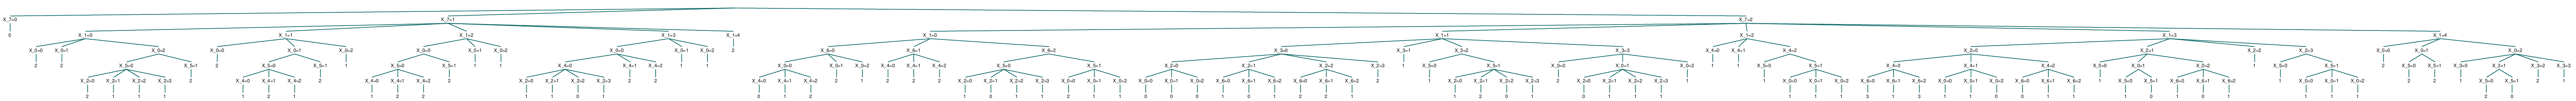

In [12]:
agent.plot_tree()

In [16]:
import re
accuracies = []
iterations = []
iteration = lambda s : int(re.split('_', s[:-4])[-1])
list_weights = sorted(os.listdir('q_learning_nursery/'), key = iteration)

In [17]:
for i, path in enumerate(list_weights):
    agent.load_weights('q_learning_nursery/' + path)
    agent.greedy_policy()
    accuracies.append(agent.test(env, n_test=data_train.shape[0]))
    iterations.append(iteration(path))

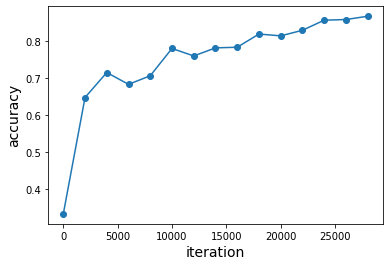

In [18]:
plt.plot(iterations, accuracies, 'o-')
plt.xlabel('iteration', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.show()

## 5 folds cross-validation

In [8]:
kf = KFold()

In [20]:
accuracies = []
i = 1
for train_indices, test_indices in kf.split(data, data[:, -1]):
    data_train, data_test = data[train_indices, :], data[test_indices, :]
    categories = [len(set(data_train[:, j])) for j in range(data_train.shape[1]-1)]
    rewards_queries = dict([(i, -.5) for i in range(len(categories))])
    env_train = Environment(data_train, rewards_queries, r_plus=5, r_minus=-10)
    agent = Agent(categories=categories, labels=list(env_train.maps[data_train.shape[1]-1].values()), min_queries=1, max_queries=5)
    agent.q_learning(env_train, n_episodes=3*data_train.shape[0], path_save='q_learning_nursery_'+'fold_'+str(i)+'/', n_save=data_train.shape[0]//5, 
                     epsilon_start=1, epsilon_stop=0.1, decay_rate=1e-5)
    agent.greedy_policy()
    env_test = Environment(data_test, rewards_queries)
    accuracy = agent.test(env_test, len(test_indices))
    accuracies.append(accuracy)
    print('Fold %d : accuracy=%.3f' %(i, accuracy))
    print('\n')
    i += 1
    

Episode : 0 , epsilon : 1.000


/home/otmane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in double_scalars


Episode : 2073 , epsilon : 0.908
Episode : 4146 , epsilon : 0.819
Episode : 6219 , epsilon : 0.733
Episode : 8292 , epsilon : 0.649
Episode : 10365 , epsilon : 0.569
Episode : 12438 , epsilon : 0.493
Episode : 14511 , epsilon : 0.421
Episode : 16584 , epsilon : 0.354
Episode : 18657 , epsilon : 0.291
Episode : 20730 , epsilon : 0.236
Episode : 22803 , epsilon : 0.191
Episode : 24876 , epsilon : 0.155
Episode : 26949 , epsilon : 0.130
Episode : 29022 , epsilon : 0.115
Episode : 31095 , epsilon : 0.107
Fold 1 : accuracy=0.840


Episode : 0 , epsilon : 1.000
Episode : 2073 , epsilon : 0.908
Episode : 4146 , epsilon : 0.819
Episode : 6219 , epsilon : 0.732
Episode : 8292 , epsilon : 0.649
Episode : 10365 , epsilon : 0.569
Episode : 12438 , epsilon : 0.493
Episode : 14511 , epsilon : 0.420
Episode : 16584 , epsilon : 0.353
Episode : 18657 , epsilon : 0.291
Episode : 20730 , epsilon : 0.236
Episode : 22803 , epsilon : 0.190
Episode : 24876 , epsilon : 0.155
Episode : 26949 , epsilon : 0.130


In [10]:
accuracies_train_folds = {}
accuracies_test_folds = {}
iterations_folds = {}
j = 1
for train_indices, test_indices in kf.split(data, data[:, -1]):
    data_train, data_test = data[train_indices, :], data[test_indices, :]
    categories = [len(set(data_train[:, j])) for j in range(data_train.shape[1]-1)]
    rewards_queries = dict([(i, -.5) for i in range(len(categories))])
    env_train = Environment(data_train, rewards_queries, r_plus=5, r_minus=-10)
    env_test = Environment(data_test, rewards_queries, r_plus=5, r_minus=-10)
    agent = Agent(categories=categories, labels=list(env_train.maps[data.shape[1]-1].values()), min_queries=1, max_queries=5)
    path_fold = 'q_learning_nursery_'+'fold_'+str(j)+'/'
    accuracies_train_fold = []
    accuracies_test_fold = []
    iterations_fold = []
    iteration = lambda s : int(re.split('_', s[:-4])[-1])
    list_weights = sorted(os.listdir(path_fold), key = iteration)
    for i, path in enumerate(list_weights):
        agent.load_weights(path_fold + path)
        agent.greedy_policy()
        accuracies_train_fold.append(agent.test(env_train, n_test=data_train.shape[0]))
        accuracies_test_fold.append(agent.test(env_test, n_test=data_test.shape[0]))
        iterations_fold.append(iteration(path))
        
    accuracies_train_folds[j] = accuracies_train_fold
    accuracies_test_folds[j] = accuracies_test_fold
    iterations_folds[j] = iterations_fold
    print('Finished fold : %d' %j)
    j += 1

Finished fold : 1
Finished fold : 2
Finished fold : 3
Finished fold : 4
Finished fold : 5


In [11]:
path_fold = 'q_learning_nursery_fold_1/'
iteration = lambda s : int(re.split('_', s[:-4])[-1])
list_weights = sorted(os.listdir(path_fold), key = iteration)
accuracies_train_folds = np.empty((5, len(list_weights)))
accuracies_test_folds = np.empty((5, len(list_weights)))
iterations = []
for path in list_weights:
    iterations.append(iteration(path))
    
i=0
for train_indices, test_indices in kf.split(data, data[:, -1]):
    data_train, data_test = data[train_indices, :], data[test_indices, :]
    categories = [len(set(data_train[:, j])) for j in range(data_train.shape[1]-1)]
    rewards_queries = dict([(i, -.5) for i in range(len(categories))])
    env_train = Environment(data_train, rewards_queries, r_plus=5, r_minus=-10)
    env_test = Environment(data_test, rewards_queries, r_plus=5, r_minus=-10)
#     agent = Agent(categories=categories, labels=list(env_train.maps[data.shape[1]-1].values()), min_queries=2, max_queries=3)
    agent = Agent(categories=categories, labels=list(env_train.maps[data.shape[1]-1].values()), min_queries=1, max_queries=5)
    path_fold = 'q_learning_nursery_fold_'+str(i+1)+'/'
    list_weights = sorted(os.listdir(path_fold), key = iteration)
    for j, path in enumerate(list_weights):
        agent.load_weights(path_fold + path)
        agent.greedy_policy()
        accuracies_train_folds[i, j] = agent.test(env_train, n_test=data_train.shape[0])
        accuracies_test_folds[i, j] = agent.test(env_test, n_test=data_test.shape[0])
        
    print('Finished fold : %d' %(i+1))
    i += 1
    

Finished fold : 1
Finished fold : 2
Finished fold : 3
Finished fold : 4
Finished fold : 5


In [28]:
print('crossval mean = %.4f' %accuracies_test_folds[:, -1].mean())
print('crossval std = %.4f' %accuracies_test_folds[:, -1].std())

crossval mean = 0.8531
crossval std = 0.0117


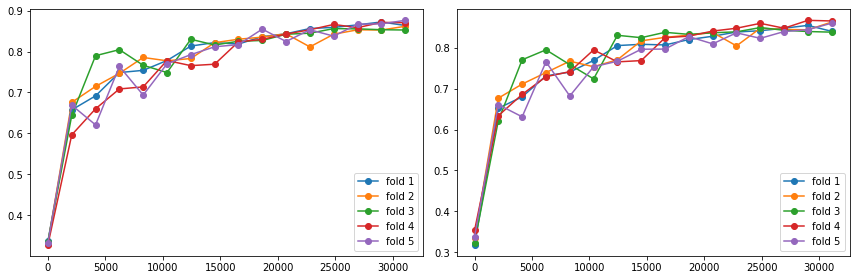

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
accuracies_train_mean = accuracies_train_folds.mean(axis=0)
accuracies_train_std = accuracies_train_folds.std(axis=0)
accuracies_test_mean = accuracies_test_folds.mean(axis=0)
accuracies_test_std = accuracies_test_folds.std(axis=0)
for i in range(5):
    axs[0].plot(iterations, accuracies_train_folds[i], 'o-', label='fold %d' %(i+1))
    axs[0].legend()
    axs[1].plot(iterations, accuracies_test_folds[i], 'o-', label='fold %d' %(i+1))
    axs[1].legend()
    
plt.tight_layout()
plt.savefig('../fig/q_learning_nursery_folds.png')
plt.show()